# Init

In [1]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import joblib
import lightgbm
import catboost as cb
import xgboost as xgb
import optuna.integration.lightgbm as optlgb

from itertools import combinations
from pathlib import Path
from joblib import Parallel, delayed
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, PowerTransformer, PolynomialFeatures, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, brier_score_loss, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, ClassNamePrefixFeaturesOutMixin, BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

rng = np.random.RandomState(1234567890)

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/train.csv.gz").rename(columns=lambda x: x.strip().lower()).drop(columns="id")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/test.csv.gz").rename(columns=lambda x: x.strip().lower())
jm1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/jm1.csv.gz").rename(columns=lambda x: x.strip().lower())

for c in jm1.columns:
    if jm1[c].dtype == "object":
        jm1[c] = pd.to_numeric(jm1[c], errors="coerce")
jm1 = jm1.dropna(how="any")

train = pd.concat([train, jm1], axis=0).reset_index(drop=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112643 entries, 0 to 112642
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                112643 non-null  float64
 1   v(g)               112643 non-null  float64
 2   ev(g)              112643 non-null  float64
 3   iv(g)              112643 non-null  float64
 4   n                  112643 non-null  float64
 5   v                  112643 non-null  float64
 6   l                  112643 non-null  float64
 7   d                  112643 non-null  float64
 8   i                  112643 non-null  float64
 9   e                  112643 non-null  float64
 10  b                  112643 non-null  float64
 11  t                  112643 non-null  float64
 12  locode             112643 non-null  int64  
 13  locomment          112643 non-null  int64  
 14  loblank            112643 non-null  int64  
 15  loccodeandcomment  112643 non-null  int64  
 16  un

In [5]:
train.agg("nunique")

loc                   383
v(g)                  112
ev(g)                  76
iv(g)                  91
n                     842
v                    4539
l                      56
d                    3373
i                    5206
e                    8757
b                     323
t                    8642
locode                300
locomment              92
loblank                97
loccodeandcomment      34
uniq_op                72
uniq_opnd             181
total_op              632
total_opnd            490
branchcount           152
defects                 2
dtype: int64

In [6]:
train.groupby("defects").agg(["min", "mean", "median", "max"]).round(2).T

defects               False    True 
loc         min        1.00     1.00
            mean      27.78    72.62
            median    19.00    50.00
            max     3442.00  3442.00
v(g)        min        1.00     1.00
...                     ...      ...
total_opnd  max     3021.00  3021.00
branchcount min        1.00     1.00
            mean       7.47    18.70
            median     5.00    11.00
            max      485.00   826.00

[84 rows x 2 columns]

In [7]:
train.groupby("defects")["loc"].count()

defects
False    87476
True     25167
Name: loc, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[:-1]], train["defects"], test_size=0.2, random_state=rng, stratify=train["defects"])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90114, 21), (22529, 21), (90114,), (22529,))

In [9]:
Xy_train = pd.concat([X_train, y_train.to_frame("defects")], axis=1)
Xy_train.shape

(90114, 22)

# Dirty Modelling

In [ ]:
def cv_score(model):
    return np.mean(cross_val_score(model, train.drop(columns="defects"), train["defects"], scoring="neg_brier_score", cv=5, n_jobs=-1))

In [ ]:
{
    "dummy": cv_score(DummyClassifier(random_state=rng)),
    "xgb": cv_score(xgb.XGBClassifier(random_state=rng)),
    "lgbm": cv_score(LGBMClassifier(random_state=rng)),
    "hgbm": cv_score(HistGradientBoostingClassifier(random_state=rng)),
    "rf": cv_score(RandomForestClassifier(random_state=rng)),
}

{'dummy': -0.173504981513748,
 'xgb': -0.13928878454223687,
 'lgbm': -0.13685716429206524,
 'hgbm': -0.13660524174462965,
 'rf': -0.14630774256563145}

# Analysis

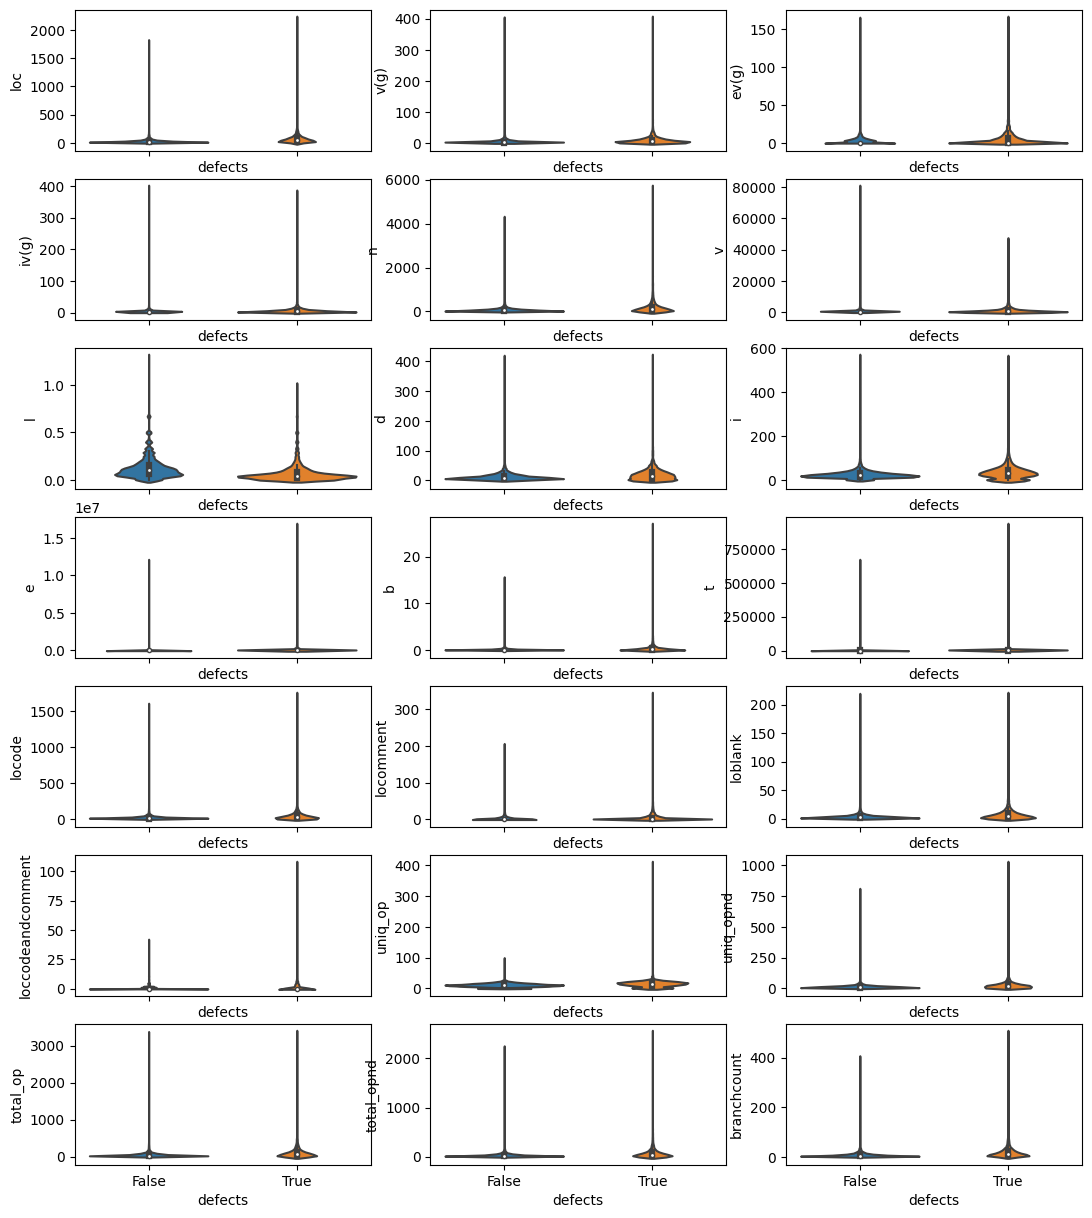

In [ ]:
fig, ax = plt.subplots(7, 3, figsize=[13, 15], sharex=True)

for i, c in enumerate(X_train.columns):
    sns.violinplot(Xy_train, x="defects", y=c, ax=ax[int(np.floor(i / 3))][int(np.floor(i % 3))])

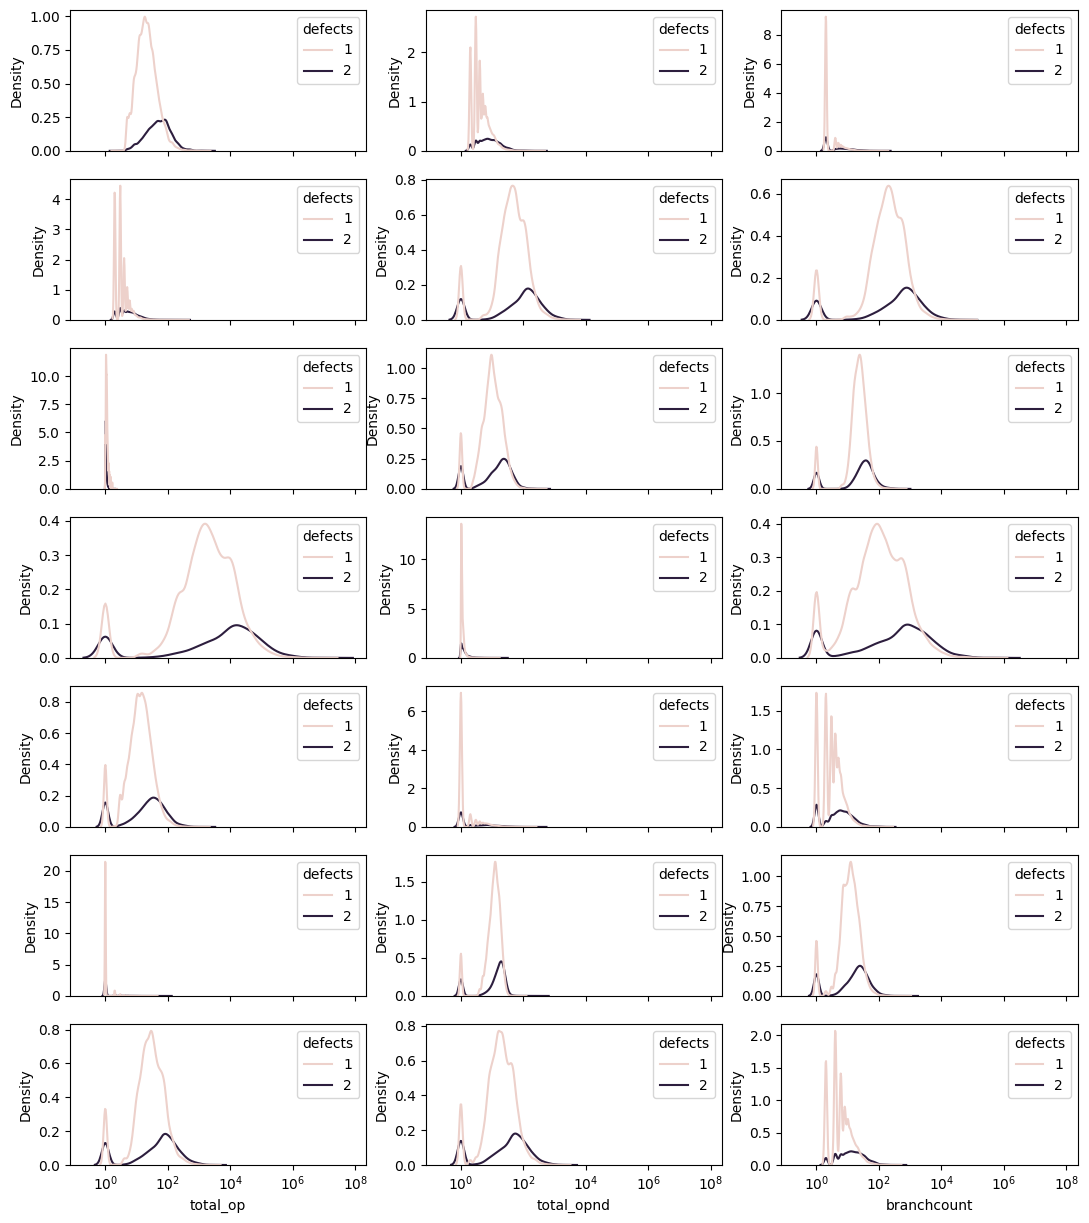

In [ ]:
fig, ax = plt.subplots(7, 3, figsize=[13, 15], sharex=True)

for i, c in enumerate(X_train.columns):
    sns.kdeplot(Xy_train.add(1), x=c, hue="defects", ax=ax[int(np.floor(i / 3))][int(np.floor(i % 3))], log_scale=True)

In [ ]:
trx = [
    ("P", PowerTransformer()),
    ("S", StandardScaler()),
    ("M", MinMaxScaler(clip=True)),
    ("2", FunctionTransformer(func=lambda x: x**2)),
    ("R", RobustScaler())
]

trx_res = []
for name, t in trx:
    pipe = make_pipeline(t, LogisticRegression(penalty=None, dual=False, solver="newton-cholesky"))
    tmp = cross_validate(pipe, X_train, y_train, scoring=("roc_auc", "accuracy", "f1", "neg_brier_score"), cv=5, n_jobs=-1)
    trx_res.append([name, np.round(np.mean(tmp["test_roc_auc"]), 4), np.round(np.mean(tmp["test_accuracy"]), 4), np.round(np.mean(tmp["test_f1"]), 4), np.round(np.mean(tmp["test_neg_brier_score"]), 4)])

ptab = PrettyTable()
ptab.field_names = ["pairs", "auc", "acc", "f1", "neg_brier_score"]
ptab.add_rows(trx_res)
ptab.sortby = "f1"
ptab.reversesort = True
print(ptab)

+-------+--------+--------+--------+-----------------+
| pairs |  auc   |  acc   |   f1   | neg_brier_score |
+-------+--------+--------+--------+-----------------+
|   P   | 0.7792 | 0.8105 | 0.4435 |     -0.1379     |
|   2   | 0.6502 | 0.2234 | 0.3652 |     -0.2498     |
|   S   | 0.772  | 0.8064 | 0.3602 |     -0.1409     |
|   M   | 0.772  | 0.8064 | 0.3602 |     -0.1409     |
|   R   | 0.772  | 0.8063 | 0.3601 |     -0.1409     |
+-------+--------+--------+--------+-----------------+


In [ ]:
res = []
for cs in combinations(X_train.columns, 2):
    pipe = make_pipeline(PowerTransformer(), LogisticRegression(penalty=None, dual=False, solver="newton-cholesky"))
    tmp = cross_validate(pipe, X_train[list(cs)], y_train, scoring=("roc_auc", "accuracy", "f1", "neg_brier_score"), cv=5, n_jobs=-1)
    res.append([cs, np.round(np.mean(tmp["test_roc_auc"]), 4), np.round(np.mean(tmp["test_accuracy"]), 4), np.round(np.mean(tmp["test_f1"]), 4), np.round(np.mean(tmp["test_neg_brier_score"]), 4)])

ptab = PrettyTable()
ptab.field_names = ["pairs", "auc", "acc", "f1", "neg_brier_score"]
ptab.add_rows(res)
ptab.sortby = "f1"
ptab.reversesort = True
print(ptab)

+--------------------------------------+--------+--------+--------+-----------------+
|                pairs                 |  auc   |  acc   |   f1   | neg_brier_score |
+--------------------------------------+--------+--------+--------+-----------------+
|             ('loc', 't')             | 0.7745 | 0.809  | 0.4107 |     -0.1393     |
|             ('loc', 'd')             | 0.7746 | 0.8091 | 0.4105 |     -0.1392     |
|             ('loc', 'e')             | 0.7746 | 0.809  | 0.4097 |     -0.1393     |
|        ('loc', 'total_opnd')         | 0.7745 | 0.8088 | 0.4091 |     -0.1393     |
|             ('loc', 'v')             | 0.7746 | 0.809  | 0.4089 |     -0.1393     |
|          ('loc', 'locode')           | 0.7747 | 0.8088 | 0.4088 |     -0.1393     |
|         ('loc', 'total_op')          | 0.7746 | 0.8089 | 0.4086 |     -0.1393     |
|             ('loc', 'n')             | 0.7746 | 0.8089 | 0.4086 |     -0.1393     |
|         ('loc', 'uniq_opnd')         | 0.7744 | 0.80

In [ ]:
mi = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=rng)
mi = list(zip(X_train.columns, mi))
mi = sorted(mi, key=lambda x: x[1], reverse=True)

strong_univars = [c for c, s in mi if s > 0.06]
weak_univars = [c for c, s in mi if s <= 0.06]
mi

[('loc', 0.0951674684369328),
 ('locode', 0.08199243589859706),
 ('t', 0.07980795825076936),
 ('e', 0.07947686073528759),
 ('v', 0.0783532621519496),
 ('n', 0.0780179210136458),
 ('b', 0.07783328341171125),
 ('total_op', 0.07712560828150883),
 ('total_opnd', 0.07695359950572178),
 ('uniq_opnd', 0.07434829751302718),
 ('i', 0.07068946340184867),
 ('d', 0.06915508067136344),
 ('branchcount', 0.06542511726579248),
 ('v(g)', 0.065369141069892),
 ('uniq_op', 0.06475948083383165),
 ('l', 0.06428313692728183),
 ('iv(g)', 0.06290094726060302),
 ('loblank', 0.0523988018542616),
 ('ev(g)', 0.03396585179926248),
 ('locomment', 0.025139454254499594),
 ('loccodeandcomment', 0.007264039327074645)]

# Feature Engineering

In [10]:
class WOETransformer(BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin):
    def __init__(self, eps: int = 1):
        self.woe_mapping_ = {}
        self.eps = eps

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        check_X_y(X, y, accept_sparse=False)

        Xy = pd.concat([X, y.astype(int).to_frame("target")], axis=1)
        self.feature_names_in_ = X.columns.tolist()
        self.n_features_ = X.shape[1]

        del X, y

        for c in self.feature_names_in_:
            self.woe_mapping_[c] = Xy.groupby(c)["target"].apply(lambda x: sum(x) / (sum(x == 0) + self.eps)).to_dict()

        self._n_features_out = len(self.woe_mapping_)
        self.is_fitted_ = True

        return self

    def transform(self, X):
        check_is_fitted(self, "is_fitted_")
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')

        for c in X.columns:
            X.loc[:, c] = X[c].map(self.woe_mapping_[c])

        return X.values

    def get_feature_names_out(self, input_features=None):
        return [c for c in self.feature_names_in_]

In [11]:
fteng_poly = FeatureUnion([
    ("poly", PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ("t1", "passthrough"),
], n_jobs=-1)

fteng_bins = FeatureUnion([
    ("bins", KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="kmeans", random_state=rng)),
    ("t2", "passthrough"),
])

fteng_woe = ColumnTransformer([
    ("woe", WOETransformer(), make_column_selector(pattern="bins_.*")),
    ("t3", "drop", make_column_selector(pattern="bins_.*"))
], remainder="passthrough")

fteng_pipe = make_pipeline(fteng_poly, fteng_bins, fteng_woe)
fteng_pipe.set_output(transform="pandas")
X_train_1 = fteng_pipe.fit_transform(X_train, y_train)
X_train_1.shape

(90114, 546)

# Feature Selection

In [12]:
mi_p = Path("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/mi.pkl.gz")

if mi_p.exists():
    with mi_p.open("rb") as fn:
        mi = joblib.load(fn)
else:
    mi = mutual_info_classif(X_train_1, y_train, discrete_features=False, random_state=rng)
    mi = list(zip(X_train_1.columns, mi))

    with mi_p.open("wb") as fn:
        joblib.dump(mi, fn, compress=9)

mitab = PrettyTable()
mitab.field_names = ["Feature", "MutualInfo"]
mitab.add_rows(mi)
mitab.sortby = "MutualInfo"
mitab.reversesort = True
print(mitab)

+----------------------------------------------------+----------------------+
|                      Feature                       |      MutualInfo      |
+----------------------------------------------------+----------------------+
|             remainder__t2__poly__loc^2             | 0.09464037944249903  |
|              remainder__t2__poly__loc              | 0.09295590780702767  |
|               remainder__t2__t1__loc               | 0.09289234869471508  |
|        remainder__t2__poly__loc branchcount        | 0.09287965607451998  |
|           remainder__t2__poly__loc v(g)            | 0.08909912405640452  |
|           remainder__t2__poly__loc iv(g)           | 0.08880446147963794  |
|          remainder__t2__poly__loc locode           | 0.08582700485759864  |
|             remainder__t2__poly__loc n             |  0.0853347034134131  |
|         remainder__t2__poly__loc total_op          | 0.08413127635228124  |
|         remainder__t2__poly__loc uniq_opnd         | 0.0840040

In [13]:
X_train_2 = X_train_1[[c for c, m in mi if m >= 0.05]]
X_train_2.shape

(90114, 220)

In [14]:
rfe_p = Path("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/rfe.pkl.gz")

if rfe_p.exists():
    with rfe_p.open("rb") as fn:
        rfe = joblib.load(fn)
else:
    rfe = RFECV(LGBMClassifier(random_state=rng), cv=3, step=4, n_jobs=-1, scoring="neg_brier_score", min_features_to_select=20)
    rfe.fit(X_train_2, y_train)

    with rfe_p.open("wb") as fn:
        joblib.dump(rfe, fn, compress=9)

In [15]:
pd.DataFrame(rfe.cv_results_)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,-0.137515,0.001365,-0.135587,-0.138571,-0.138385
1,-0.137413,0.001537,-0.135247,-0.138646,-0.138346
2,-0.137574,0.001578,-0.135345,-0.138793,-0.138583
3,-0.137707,0.001355,-0.135803,-0.138843,-0.138476
4,-0.137537,0.001507,-0.135409,-0.138711,-0.138489
5,-0.137603,0.001518,-0.135456,-0.138700,-0.138653
6,-0.137467,0.001421,-0.135467,-0.138642,-0.138293
7,-0.137515,0.001399,-0.135540,-0.138610,-0.138395
8,-0.137601,0.001517,-0.135456,-0.138652,-0.138694
9,-0.137515,0.001325,-0.135645,-0.138557,-0.138343


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

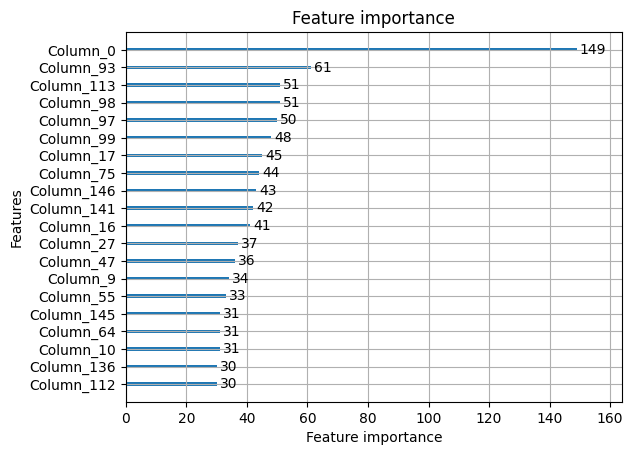

In [16]:
lightgbm.plot_importance(rfe.estimator_, max_num_features=20)

In [17]:
X_train_3 = X_train_2[X_train_2.columns[rfe.support_]]
X_train_3.shape

(90114, 156)

# Hyperparam Tuning

In [ ]:
del X_train_1, X_train_2

## LightGBM

In [ ]:
lgb_study = optuna.create_study(study_name="lgb", direction="minimize")
dtrain = optlgb.Dataset(X_train_3, label=y_train)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

tuner = optlgb.LightGBMTunerCV(
    params,
    dtrain,
    study=lgb_study,
    nfold=3,
    seed=1234567890,
    callbacks=[early_stopping(100), log_evaluation(100)]
)

tuner.run()

/usr/local/lib/python3.10/dist-packages/optuna/integration/_lightgbm_tuner/optimize.py:429: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(

feature_fraction, val_score: 0.433709:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.435097 + 0.00291938



feature_fraction, val_score: 0.433604:  14%|#4        | 1/7 [00:24<02:24, 24.02s/it]

Early stopping, best iteration is:
[42]	cv_agg's valid binary_logloss: 0.433604 + 0.00296362
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434989 + 0.00303592



feature_fraction, val_score: 0.433584:  29%|##8       | 2/7 [00:42<01:45, 21.03s/it]

Early stopping, best iteration is:
[37]	cv_agg's valid binary_logloss: 0.433584 + 0.00291479
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434743 + 0.00253315



feature_fraction, val_score: 0.433564:  43%|####2     | 3/7 [01:18<01:50, 27.61s/it]

Early stopping, best iteration is:
[47]	cv_agg's valid binary_logloss: 0.433564 + 0.00272678
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.435088 + 0.00285401



feature_fraction, val_score: 0.433564:  57%|#####7    | 4/7 [01:43<01:20, 26.68s/it]

Early stopping, best iteration is:
[37]	cv_agg's valid binary_logloss: 0.433709 + 0.00295198
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434491 + 0.00291112



feature_fraction, val_score: 0.433509:  71%|#######1  | 5/7 [01:58<00:47, 23.75s/it]


Early stopping, best iteration is:
[43]	cv_agg's valid binary_logloss: 0.433509 + 0.00285289



num_leaves, val_score: 0.433509:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.449971 + 0.00360289



num_leaves, val_score: 0.433509:   5%|5         | 1/20 [00:35<11:05, 35.05s/it]

Early stopping, best iteration is:
[24]	cv_agg's valid binary_logloss: 0.437916 + 0.00250189
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.447393 + 0.00359731



num_leaves, val_score: 0.433509:  10%|#         | 2/20 [01:09<10:27, 34.85s/it]

Early stopping, best iteration is:
[25]	cv_agg's valid binary_logloss: 0.437229 + 0.00253284
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.445488 + 0.00340667



num_leaves, val_score: 0.433509:  15%|#5        | 3/20 [01:51<10:44, 37.93s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid binary_logloss: 0.436685 + 0.00248195
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.447507 + 0.00262115



num_leaves, val_score: 0.433509:  20%|##        | 4/20 [02:50<12:22, 46.40s/it]

Early stopping, best iteration is:
[25]	cv_agg's valid binary_logloss: 0.437139 + 0.00221433
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434446 + 0.00265418



num_leaves, val_score: 0.433392:  25%|##5       | 5/20 [03:07<08:53, 35.56s/it]

Early stopping, best iteration is:
[41]	cv_agg's valid binary_logloss: 0.433392 + 0.0027723
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434245 + 0.0029376
[200]	cv_agg's valid binary_logloss: 0.43349 + 0.00293375
[300]	cv_agg's valid binary_logloss: 0.43324 + 0.00293538
[400]	cv_agg's valid binary_logloss: 0.433194 + 0.00294404
[500]	cv_agg's valid binary_logloss: 0.433226 + 0.00295423



num_leaves, val_score: 0.433172:  30%|###       | 6/20 [03:52<09:05, 38.98s/it]

Early stopping, best iteration is:
[469]	cv_agg's valid binary_logloss: 0.433172 + 0.00292022
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.436666 + 0.0028591
[200]	cv_agg's valid binary_logloss: 0.435433 + 0.00284112
[300]	cv_agg's valid binary_logloss: 0.434849 + 0.00282623
[400]	cv_agg's valid binary_logloss: 0.434495 + 0.00282538
[500]	cv_agg's valid binary_logloss: 0.434279 + 0.0028188
[600]	cv_agg's valid binary_logloss: 0.434118 + 0.00280614
[700]	cv_agg's valid binary_logloss: 0.433999 + 0.00279417
[800]	cv_agg's valid binary_logloss: 0.433889 + 0.00278483
[900]	cv_agg's valid binary_logloss: 0.433836 + 0.00279861



num_leaves, val_score: 0.433172:  35%|###5      | 7/20 [04:41<09:06, 42.07s/it]

[1000]	cv_agg's valid binary_logloss: 0.433783 + 0.00281964
Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid binary_logloss: 0.433777 + 0.00281541
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.433387 + 0.00278166



num_leaves, val_score: 0.433172:  40%|####      | 8/20 [04:58<06:49, 34.14s/it]

Early stopping, best iteration is:
[57]	cv_agg's valid binary_logloss: 0.433218 + 0.00280923
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.438516 + 0.00264012



num_leaves, val_score: 0.433172:  45%|####5     | 9/20 [05:16<05:20, 29.11s/it]

Early stopping, best iteration is:
[30]	cv_agg's valid binary_logloss: 0.434707 + 0.00285747
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.439043 + 0.00329715



num_leaves, val_score: 0.433172:  50%|#####     | 10/20 [05:39<04:34, 27.41s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid binary_logloss: 0.43482 + 0.00273988
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.436921 + 0.00271722



num_leaves, val_score: 0.433172:  55%|#####5    | 11/20 [06:04<03:58, 26.52s/it]

Early stopping, best iteration is:
[37]	cv_agg's valid binary_logloss: 0.434318 + 0.00271903
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.443492 + 0.00312162



num_leaves, val_score: 0.433172:  60%|######    | 12/20 [06:33<03:38, 27.31s/it]

Early stopping, best iteration is:
[26]	cv_agg's valid binary_logloss: 0.435678 + 0.00260968
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434245 + 0.0029376
[200]	cv_agg's valid binary_logloss: 0.43349 + 0.00293375
[300]	cv_agg's valid binary_logloss: 0.43324 + 0.00293538
[400]	cv_agg's valid binary_logloss: 0.433194 + 0.00294404
[500]	cv_agg's valid binary_logloss: 0.433226 + 0.00295423



num_leaves, val_score: 0.433172:  65%|######5   | 13/20 [07:33<04:19, 37.04s/it]

Early stopping, best iteration is:
[469]	cv_agg's valid binary_logloss: 0.433172 + 0.00292022
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.441081 + 0.00271354



num_leaves, val_score: 0.433172:  70%|#######   | 14/20 [08:35<04:27, 44.64s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid binary_logloss: 0.435456 + 0.00265909
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.435529 + 0.00228065



num_leaves, val_score: 0.433172:  75%|#######5  | 15/20 [08:55<03:06, 37.27s/it]

Early stopping, best iteration is:
[37]	cv_agg's valid binary_logloss: 0.433937 + 0.00272881
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.433387 + 0.00278166



num_leaves, val_score: 0.433172:  80%|########  | 16/20 [09:09<02:00, 30.21s/it]

Early stopping, best iteration is:
[57]	cv_agg's valid binary_logloss: 0.433218 + 0.00280923
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.436666 + 0.0028591
[200]	cv_agg's valid binary_logloss: 0.435433 + 0.00284112
[300]	cv_agg's valid binary_logloss: 0.434849 + 0.00282623
[400]	cv_agg's valid binary_logloss: 0.434495 + 0.00282538
[500]	cv_agg's valid binary_logloss: 0.434279 + 0.0028188
[600]	cv_agg's valid binary_logloss: 0.434118 + 0.00280614
[700]	cv_agg's valid binary_logloss: 0.433999 + 0.00279417
[800]	cv_agg's valid binary_logloss: 0.433889 + 0.00278483
[900]	cv_agg's valid binary_logloss: 0.433836 + 0.00279861



num_leaves, val_score: 0.433172:  85%|########5 | 17/20 [10:07<01:55, 38.57s/it]

[1000]	cv_agg's valid binary_logloss: 0.433783 + 0.00281964
Did not meet early stopping. Best iteration is:
[997]	cv_agg's valid binary_logloss: 0.433777 + 0.00281541
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.43533 + 0.00270962



num_leaves, val_score: 0.433172:  90%|######### | 18/20 [10:23<01:03, 31.82s/it]

Early stopping, best iteration is:
[39]	cv_agg's valid binary_logloss: 0.433864 + 0.0029906
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.439779 + 0.00283123



num_leaves, val_score: 0.433172:  95%|#########5| 19/20 [10:43<00:28, 28.24s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid binary_logloss: 0.435264 + 0.00240601
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.435245 + 0.00316905



num_leaves, val_score: 0.433172: 100%|##########| 20/20 [10:58<00:00, 32.90s/it]


Early stopping, best iteration is:
[38]	cv_agg's valid binary_logloss: 0.433743 + 0.00307687



bagging, val_score: 0.433172:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



bagging, val_score: 0.433143:  10%|#         | 1/10 [00:25<03:47, 25.28s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434228 + 0.00275754
[200]	cv_agg's valid binary_logloss: 0.433509 + 0.00270276
[300]	cv_agg's valid binary_logloss: 0.433351 + 0.00288188
[400]	cv_agg's valid binary_logloss: 0.433446 + 0.00291045



bagging, val_score: 0.433143:  20%|##        | 2/10 [00:47<03:06, 23.37s/it]

Early stopping, best iteration is:
[358]	cv_agg's valid binary_logloss: 0.433239 + 0.00288212
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434268 + 0.00287448
[200]	cv_agg's valid binary_logloss: 0.433501 + 0.00289586
[300]	cv_agg's valid binary_logloss: 0.433314 + 0.00283593
[400]	cv_agg's valid binary_logloss: 0.433307 + 0.00285502



bagging, val_score: 0.433143:  30%|###       | 3/10 [01:09<02:40, 22.95s/it]

Early stopping, best iteration is:
[367]	cv_agg's valid binary_logloss: 0.433265 + 0.002864
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434359 + 0.00285896
[200]	cv_agg's valid binary_logloss: 0.433665 + 0.00277923
[300]	cv_agg's valid binary_logloss: 0.433422 + 0.00307989
[400]	cv_agg's valid binary_logloss: 0.433563 + 0.00311415



bagging, val_score: 0.433143:  40%|####      | 4/10 [01:28<02:06, 21.09s/it]

Early stopping, best iteration is:
[317]	cv_agg's valid binary_logloss: 0.433345 + 0.00313525
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434316 + 0.00287943
[200]	cv_agg's valid binary_logloss: 0.43344 + 0.00289235
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00293658
[400]	cv_agg's valid binary_logloss: 0.433227 + 0.00294495
[500]	cv_agg's valid binary_logloss: 0.433242 + 0.00298225



bagging, val_score: 0.433143:  50%|#####     | 5/10 [02:02<02:09, 25.85s/it]

Early stopping, best iteration is:
[441]	cv_agg's valid binary_logloss: 0.433188 + 0.00293238
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434286 + 0.0029526
[200]	cv_agg's valid binary_logloss: 0.433524 + 0.00292722
[300]	cv_agg's valid binary_logloss: 0.433326 + 0.0029695
[400]	cv_agg's valid binary_logloss: 0.433278 + 0.00295923



bagging, val_score: 0.433143:  60%|######    | 6/10 [02:31<01:47, 26.97s/it]

Early stopping, best iteration is:
[381]	cv_agg's valid binary_logloss: 0.433269 + 0.00301103
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434041 + 0.0029461
[200]	cv_agg's valid binary_logloss: 0.433455 + 0.00291682
[300]	cv_agg's valid binary_logloss: 0.433301 + 0.00287476
[400]	cv_agg's valid binary_logloss: 0.433275 + 0.00277934
[500]	cv_agg's valid binary_logloss: 0.433431 + 0.00289333



bagging, val_score: 0.433143:  70%|#######   | 7/10 [02:56<01:18, 26.31s/it]

Early stopping, best iteration is:
[407]	cv_agg's valid binary_logloss: 0.43324 + 0.00281911
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434262 + 0.0028549
[200]	cv_agg's valid binary_logloss: 0.4335 + 0.0028612
[300]	cv_agg's valid binary_logloss: 0.433275 + 0.0029631
[400]	cv_agg's valid binary_logloss: 0.43317 + 0.00294118



bagging, val_score: 0.433143:  80%|########  | 8/10 [03:26<00:55, 27.58s/it]

Early stopping, best iteration is:
[391]	cv_agg's valid binary_logloss: 0.43316 + 0.00295902
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434261 + 0.00278885
[200]	cv_agg's valid binary_logloss: 0.433461 + 0.00273537
[300]	cv_agg's valid binary_logloss: 0.433425 + 0.00280144



bagging, val_score: 0.433143:  90%|######### | 9/10 [03:50<00:26, 26.55s/it]

Early stopping, best iteration is:
[252]	cv_agg's valid binary_logloss: 0.433351 + 0.00274237
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434355 + 0.00308627
[200]	cv_agg's valid binary_logloss: 0.433526 + 0.00301761
[300]	cv_agg's valid binary_logloss: 0.433398 + 0.00290471



bagging, val_score: 0.433143: 100%|##########| 10/10 [04:08<00:00, 24.82s/it]


Early stopping, best iteration is:
[270]	cv_agg's valid binary_logloss: 0.433312 + 0.00291513



feature_fraction_stage2, val_score: 0.433143:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434421 + 0.00275876
[200]	cv_agg's valid binary_logloss: 0.43367 + 0.00271434
[300]	cv_agg's valid binary_logloss: 0.433418 + 0.00282995
[400]	cv_agg's valid binary_logloss: 0.433447 + 0.00284931



feature_fraction_stage2, val_score: 0.433143:  17%|#6        | 1/6 [00:21<01:48, 21.78s/it]

Early stopping, best iteration is:
[322]	cv_agg's valid binary_logloss: 0.433305 + 0.00286879
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.43427 + 0.00274854
[200]	cv_agg's valid binary_logloss: 0.433545 + 0.00262624
[300]	cv_agg's valid binary_logloss: 0.433343 + 0.00276833
[400]	cv_agg's valid binary_logloss: 0.433401 + 0.00279532



feature_fraction_stage2, val_score: 0.433143:  33%|###3      | 2/6 [00:38<01:15, 18.92s/it]

Early stopping, best iteration is:
[313]	cv_agg's valid binary_logloss: 0.43324 + 0.00280471
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434239 + 0.00267094
[200]	cv_agg's valid binary_logloss: 0.433528 + 0.00254447
[300]	cv_agg's valid binary_logloss: 0.43343 + 0.00267835
[400]	cv_agg's valid binary_logloss: 0.433526 + 0.00266778



feature_fraction_stage2, val_score: 0.433143:  50%|#####     | 3/6 [00:56<00:55, 18.39s/it]

Early stopping, best iteration is:
[315]	cv_agg's valid binary_logloss: 0.433374 + 0.0027082
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434259 + 0.00272312
[200]	cv_agg's valid binary_logloss: 0.433516 + 0.0026273
[300]	cv_agg's valid binary_logloss: 0.433387 + 0.0027722
[400]	cv_agg's valid binary_logloss: 0.433442 + 0.00277397



feature_fraction_stage2, val_score: 0.433143:  67%|######6   | 4/6 [01:17<00:38, 19.49s/it]

Early stopping, best iteration is:
[366]	cv_agg's valid binary_logloss: 0.433275 + 0.00276402
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434268 + 0.00271876
[200]	cv_agg's valid binary_logloss: 0.43355 + 0.00260393
[300]	cv_agg's valid binary_logloss: 0.433313 + 0.00279107
[400]	cv_agg's valid binary_logloss: 0.433353 + 0.00284544



feature_fraction_stage2, val_score: 0.433143:  83%|########3 | 5/6 [01:35<00:18, 18.83s/it]

Early stopping, best iteration is:
[365]	cv_agg's valid binary_logloss: 0.433194 + 0.00282995
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.43431 + 0.00278515
[200]	cv_agg's valid binary_logloss: 0.433571 + 0.00279442
[300]	cv_agg's valid binary_logloss: 0.433405 + 0.00290839
[400]	cv_agg's valid binary_logloss: 0.433544 + 0.00285973



feature_fraction_stage2, val_score: 0.433143: 100%|##########| 6/6 [01:56<00:00, 19.49s/it]


Early stopping, best iteration is:
[319]	cv_agg's valid binary_logloss: 0.433359 + 0.00292321



regularization_factors, val_score: 0.433143:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434228 + 0.00272037
[200]	cv_agg's valid binary_logloss: 0.433569 + 0.00270376
[300]	cv_agg's valid binary_logloss: 0.43336 + 0.00279097
[400]	cv_agg's valid binary_logloss: 0.433507 + 0.00281721



regularization_factors, val_score: 0.433143:   5%|5         | 1/20 [00:21<06:45, 21.32s/it]

Early stopping, best iteration is:
[318]	cv_agg's valid binary_logloss: 0.433263 + 0.00282951
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  10%|#         | 2/20 [00:42<06:18, 21.02s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  15%|#5        | 3/20 [01:00<05:37, 19.82s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  20%|##        | 4/20 [01:21<05:25, 20.37s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  25%|##5       | 5/20 [01:39<04:52, 19.51s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  30%|###       | 6/20 [01:57<04:25, 19.00s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  35%|###5      | 7/20 [02:18<04:14, 19.56s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  40%|####      | 8/20 [02:36<03:49, 19.10s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  45%|####5     | 9/20 [02:58<03:38, 19.84s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  50%|#####     | 10/20 [03:16<03:12, 19.30s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  55%|#####5    | 11/20 [03:34<02:49, 18.87s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  60%|######    | 12/20 [03:54<02:35, 19.44s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  65%|######5   | 13/20 [04:12<02:13, 19.05s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  70%|#######   | 14/20 [04:34<01:58, 19.78s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  75%|#######5  | 15/20 [04:52<01:35, 19.19s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  80%|########  | 16/20 [05:10<01:15, 18.82s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  85%|########5 | 17/20 [05:30<00:58, 19.40s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  90%|######### | 18/20 [05:59<00:44, 22.28s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143:  95%|#########5| 19/20 [06:17<00:20, 20.96s/it]

Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434222 + 0.00271217
[200]	cv_agg's valid binary_logloss: 0.433452 + 0.00262146
[300]	cv_agg's valid binary_logloss: 0.433249 + 0.00271627
[400]	cv_agg's valid binary_logloss: 0.433324 + 0.00276476



regularization_factors, val_score: 0.433143: 100%|##########| 20/20 [06:38<00:00, 19.95s/it]


Early stopping, best iteration is:
[320]	cv_agg's valid binary_logloss: 0.433143 + 0.00275044



min_child_samples, val_score: 0.433143:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434225 + 0.00266565
[200]	cv_agg's valid binary_logloss: 0.433454 + 0.00269203
[300]	cv_agg's valid binary_logloss: 0.433315 + 0.0027535
[400]	cv_agg's valid binary_logloss: 0.433467 + 0.00283226



min_child_samples, val_score: 0.433143:  20%|##        | 1/5 [00:17<01:10, 17.63s/it]

Early stopping, best iteration is:
[311]	cv_agg's valid binary_logloss: 0.433248 + 0.00275767
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434232 + 0.00271664
[200]	cv_agg's valid binary_logloss: 0.433514 + 0.00280049
[300]	cv_agg's valid binary_logloss: 0.433312 + 0.00288246
[400]	cv_agg's valid binary_logloss: 0.433401 + 0.00297574



min_child_samples, val_score: 0.433143:  40%|####      | 2/5 [00:35<00:53, 17.82s/it]

Early stopping, best iteration is:
[322]	cv_agg's valid binary_logloss: 0.433225 + 0.00293683
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434179 + 0.00265538
[200]	cv_agg's valid binary_logloss: 0.433369 + 0.00265547
[300]	cv_agg's valid binary_logloss: 0.433214 + 0.00279263
[400]	cv_agg's valid binary_logloss: 0.433282 + 0.00278801



min_child_samples, val_score: 0.433143:  60%|######    | 3/5 [00:56<00:38, 19.03s/it]

Early stopping, best iteration is:
[311]	cv_agg's valid binary_logloss: 0.43315 + 0.00280763
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434293 + 0.00268638
[200]	cv_agg's valid binary_logloss: 0.433441 + 0.00274016
[300]	cv_agg's valid binary_logloss: 0.433255 + 0.00284423
[400]	cv_agg's valid binary_logloss: 0.433409 + 0.00291071



min_child_samples, val_score: 0.433143:  80%|########  | 4/5 [01:14<00:18, 18.61s/it]

Early stopping, best iteration is:
[311]	cv_agg's valid binary_logloss: 0.433203 + 0.00287485
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.434282 + 0.00272355
[200]	cv_agg's valid binary_logloss: 0.433431 + 0.00268612
[300]	cv_agg's valid binary_logloss: 0.433266 + 0.00271972
[400]	cv_agg's valid binary_logloss: 0.433362 + 0.00271003



min_child_samples, val_score: 0.433143: 100%|##########| 5/5 [01:31<00:00, 18.34s/it]

Early stopping, best iteration is:
[311]	cv_agg's valid binary_logloss: 0.433196 + 0.00272929


In [ ]:
tuner.best_score, tuner.best_params

(0.4331428881285307,
 {'objective': 'binary',
  'metric': 'binary_logloss',
  'verbosity': -1,
  'boosting_type': 'gbdt',
  'feature_pre_filter': False,
  'lambda_l1': 2.915005437295791e-06,
  'lambda_l2': 3.1185298032499383e-06,
  'num_leaves': 3,
  'feature_fraction': 0.5,
  'bagging_fraction': 0.5505953287080841,
  'bagging_freq': 7,
  'min_child_samples': 20})

## XGBoost

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train_3, label=y_train)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "device": "cuda",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    history = xgb.cv(
        param,
        dtrain,
        num_boost_round=1000,
        nfold=3,
        stratified=True,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
        seed=1234567890,
        shuffle=True
    )

    mean_auc = history["test-auc-mean"].values[-1]
    return mean_auc

pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
xgb_study = optuna.create_study(pruner=pruner, direction="maximize")
xgb_study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(xgb_study.trials)))

print("Best trial:")
trial = xgb_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-22 00:27:45,675] A new study created in memory with name: no-name-fbf5cb32-9748-4d39-b175-7eebaaf0e847
[I 2023-10-22 00:28:02,318] Trial 0 finished with value: 0.7521664761543542 and parameters: {'booster': 'dart', 'lambda': 0.00106827040996746, 'alpha': 0.010496821506037195, 'max_depth': 2, 'eta': 8.38762034385935e-08, 'gamma': 8.21675270915966e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15324849031281562, 'skip_drop': 3.493975539036752e-06}. Best is trial 0 with value: 0.7521664761543542.
[I 2023-10-22 00:28:20,449] Trial 1 finished with value: 0.7754253836275855 and parameters: {'booster': 'dart', 'lambda': 0.0003901129906285116, 'alpha': 0.0039877730257646665, 'max_depth': 4, 'eta': 3.21559687743851e-06, 'gamma': 0.0227772842643351, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.3600476305638823e-06, 'skip_drop': 3.731232185898142e-07}. Best is trial 1 with value: 0

Number of finished trials: 100
Best trial:
  Value: 0.7839864185346451
  Params: 
    booster: gbtree
    lambda: 3.966316093958521e-06
    alpha: 0.000750566247495916
    max_depth: 3
    eta: 0.07802213240444274
    gamma: 1.3609469635863617e-08
    grow_policy: lossguide


## CatBoost

In [ ]:
def objective(trial: optuna.Trial) -> float:
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train.astype(int), test_size=0.2, stratify=y_train, random_state=rng)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Logloss",
        "task_type": "GPU"
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    # pruning_callback = optuna.integration.CatBoostPruningCallback(trial, "BrierScore")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        # callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    # pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    brier = brier_score_loss(valid_y, pred_labels)

    return brier


cat_study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
)
cat_study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(cat_study.trials)))

print("Best trial:")
trial = cat_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-22 01:13:53,335] A new study created in memory with name: no-name-ec9dfe9d-e63e-48ab-b4d9-fae764b195df
[I 2023-10-22 01:14:00,918] Trial 0 finished with value: 0.18781556899517282 and parameters: {'objective': 'Logloss', 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.44604270760084}. Best is trial 0 with value: 0.18781556899517282.
[I 2023-10-22 01:15:02,097] Trial 1 finished with value: 0.18831493092160018 and parameters: {'objective': 'Logloss', 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.18781556899517282.
[I 2023-10-22 01:15:39,367] Trial 2 finished with value: 0.1900349553348499 and parameters: {'objective': 'Logloss', 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.18781556899517282.
[I 2023-10-22 01:15:48,509] Trial 3 finished with value: 0.18759363036120513 and parameters: {'objective': 'CrossEntropy', 'depth': 5, 'boosti

Number of finished trials: 100
Best trial:
  Value: 0.18420906619319757
  Params: 
    objective: Logloss
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.10759565605974757


# Modelling

In [27]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'lambda_l1': 2.915005437295791e-06,
    'lambda_l2': 3.1185298032499383e-06,
    'num_leaves': 3,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5505953287080841,
    'bagging_freq': 7,
    'min_child_samples': 20,
}

xgb_params = {
    "verbosity": 0,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    "booster": "gbtree",
    "lambda": 3.966316093958521e-06,
    "alpha": 0.000750566247495916,
    "max_depth": 3,
    "eta": 0.07802213240444274,
    "gamma": 1.3609469635863617e-08,
    "grow_policy": "lossguide"
}

cat_params = {
    "objective": "Logloss",
    "depth": 5,
    "boosting_type": "Plain",
    "bootstrap_type": "Bernoulli",
    "subsample": 0.10759565605974757,
    "task_type": "GPU"
}

In [32]:
X_test_proc = fteng_pipe.transform(X_test)
X_test_proc = X_test_proc[[c for c, m in mi if m >= 0.05]]
X_test_proc = X_test_proc[X_test_proc.columns[rfe.support_]]
X_test_proc.shape

(22529, 156)

In [39]:
model = VotingClassifier([
    ("xgb", XGBClassifier(**xgb_params)),
    ("lgb", LGBMClassifier(**lgb_params)),
    ("cat", cb.CatBoostClassifier(**cat_params)),
], voting="soft").fit(X_train_3, y_train)
model

Learning rate set to 0.026318
0:	learn: 0.6780146	total: 77.3ms	remaining: 1m 17s
1:	learn: 0.6641294	total: 127ms	remaining: 1m 3s
2:	learn: 0.6504621	total: 213ms	remaining: 1m 10s
3:	learn: 0.6380077	total: 263ms	remaining: 1m 5s
4:	learn: 0.6261440	total: 319ms	remaining: 1m 3s
5:	learn: 0.6149761	total: 379ms	remaining: 1m 2s
6:	learn: 0.6044200	total: 432ms	remaining: 1m 1s
7:	learn: 0.5942414	total: 499ms	remaining: 1m 1s
8:	learn: 0.5849146	total: 548ms	remaining: 1m
9:	learn: 0.5763979	total: 602ms	remaining: 59.5s
10:	learn: 0.5682443	total: 649ms	remaining: 58.3s
11:	learn: 0.5604962	total: 677ms	remaining: 55.7s
12:	learn: 0.5533103	total: 694ms	remaining: 52.7s
13:	learn: 0.5465561	total: 712ms	remaining: 50.2s
14:	learn: 0.5401201	total: 734ms	remaining: 48.2s
15:	learn: 0.5342788	total: 764ms	remaining: 47s
16:	learn: 0.5286133	total: 799ms	remaining: 46.2s
17:	learn: 0.5231902	total: 816ms	remaining: 44.5s
18:	learn: 0.5184872	total: 839ms	remaining: 43.3s
19:	learn: 0.

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=0.000750566247495916,
                                            base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eta=0.07802213240444274,
                                            eval_metric='auc',
                                            feature_types=None,
                                            gamma=1.3609469635863617e-08,
                                            gr...
                                            n_estimators=None, ...)),
                             ('lgb',
                              LGBMClassifier(bagging_fraction=0.5505953287080841,
                                             bagging_freq=7,
                                             feature_fraction=0.5,
                                             feature_pre_filter=False,
                                             lambda_l1=2.915005437295791e-06,
                                             lambda_l2=3.1185298032499383e-06,
                                             metric='binary_logloss',
                                             num_leaves=3, objective='binary',
                                             verbosity=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x78e9d6fb4190>)],
                 voting='soft')

In [44]:
roc_auc_score(y_test, model.predict_proba(X_test_proc)[:, 1]), brier_score_loss(y_test, model.predict_proba(X_test_proc)[:, 1])

(0.7903384643520119, 0.13502218538250757)

## Train on whole dataset

In [47]:
train_proc = fteng_pipe.fit_transform(train.drop(columns="defects"), train["defects"])
train_proc = train_proc[[c for c, m in mi if m >= 0.05]]
train_proc = train_proc[train_proc.columns[rfe.support_]]
train_proc.shape

(112643, 156)

In [48]:
model = VotingClassifier([
    ("xgb", XGBClassifier(**xgb_params)),
    ("lgb", LGBMClassifier(**lgb_params)),
    ("cat", cb.CatBoostClassifier(**cat_params)),
], voting="soft").fit(train_proc, train["defects"])
model

Learning rate set to 0.025997
0:	learn: 0.6778634	total: 8.74ms	remaining: 8.73s
1:	learn: 0.6637336	total: 16.2ms	remaining: 8.1s
2:	learn: 0.6503315	total: 23.6ms	remaining: 7.86s
3:	learn: 0.6376124	total: 31ms	remaining: 7.72s
4:	learn: 0.6258061	total: 41.5ms	remaining: 8.25s
5:	learn: 0.6147459	total: 49.2ms	remaining: 8.14s
6:	learn: 0.6041916	total: 56.5ms	remaining: 8.02s
7:	learn: 0.5944987	total: 63.8ms	remaining: 7.91s
8:	learn: 0.5851294	total: 71.3ms	remaining: 7.84s
9:	learn: 0.5766334	total: 78.6ms	remaining: 7.78s
10:	learn: 0.5686582	total: 86.1ms	remaining: 7.74s
11:	learn: 0.5609888	total: 93.4ms	remaining: 7.69s
12:	learn: 0.5538772	total: 101ms	remaining: 7.65s
13:	learn: 0.5470683	total: 108ms	remaining: 7.61s
14:	learn: 0.5405927	total: 115ms	remaining: 7.56s
15:	learn: 0.5346638	total: 123ms	remaining: 7.53s
16:	learn: 0.5290610	total: 130ms	remaining: 7.52s
17:	learn: 0.5238352	total: 137ms	remaining: 7.48s
18:	learn: 0.5188831	total: 144ms	remaining: 7.45s
19

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=0.000750566247495916,
                                            base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eta=0.07802213240444274,
                                            eval_metric='auc',
                                            feature_types=None,
                                            gamma=1.3609469635863617e-08,
                                            gr...
                                            n_estimators=None, ...)),
                             ('lgb',
                              LGBMClassifier(bagging_fraction=0.5505953287080841,
                                             bagging_freq=7,
                                             feature_fraction=0.5,
                                             feature_pre_filter=False,
                                             lambda_l1=2.915005437295791e-06,
                                             lambda_l2=3.1185298032499383e-06,
                                             metric='binary_logloss',
                                             num_leaves=3, objective='binary',
                                             verbosity=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x78e9d378af80>)],
                 voting='soft')

In [54]:
test_proc = fteng_pipe.transform(test.drop(columns="id"))
test_proc = test_proc[[c for c, m in mi if m >= 0.05]]
test_proc = test_proc[test_proc.columns[rfe.support_]]
test_proc.shape

(67842, 156)

In [55]:
submission = pd.DataFrame({
    "id": test["id"],
    "defects": model.predict_proba(test_proc)[:, 1]
})
submission.shape

(67842, 2)

In [57]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/SoftwareDefects/submission.csv")